In [2]:
import torch
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pickle
from tailnflows.experiments.utils import get_project_root, load_raw_data

In [3]:
raw_data = load_raw_data('alt_shift_de_2024-02-08')

rows = []
for label, _data in raw_data.items():
    if label != 'comet':
        for test_ll, dim, df in _data:
            rows.append({
                'model': label,
                'tst_negll_per_dim': test_ll / dim,
                'df': df,
                'dim': dim
            })

In [4]:
results = pd.DataFrame(rows)
results = results[~results.isin([np.nan, np.inf, -np.inf]).any(1)]


/tmp/ipykernel_2007323/989590601.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.any and Series.any will be keyword-only.
  results = results[~results.isin([np.nan, np.inf, -np.inf]).any(1)]


### Box Plots

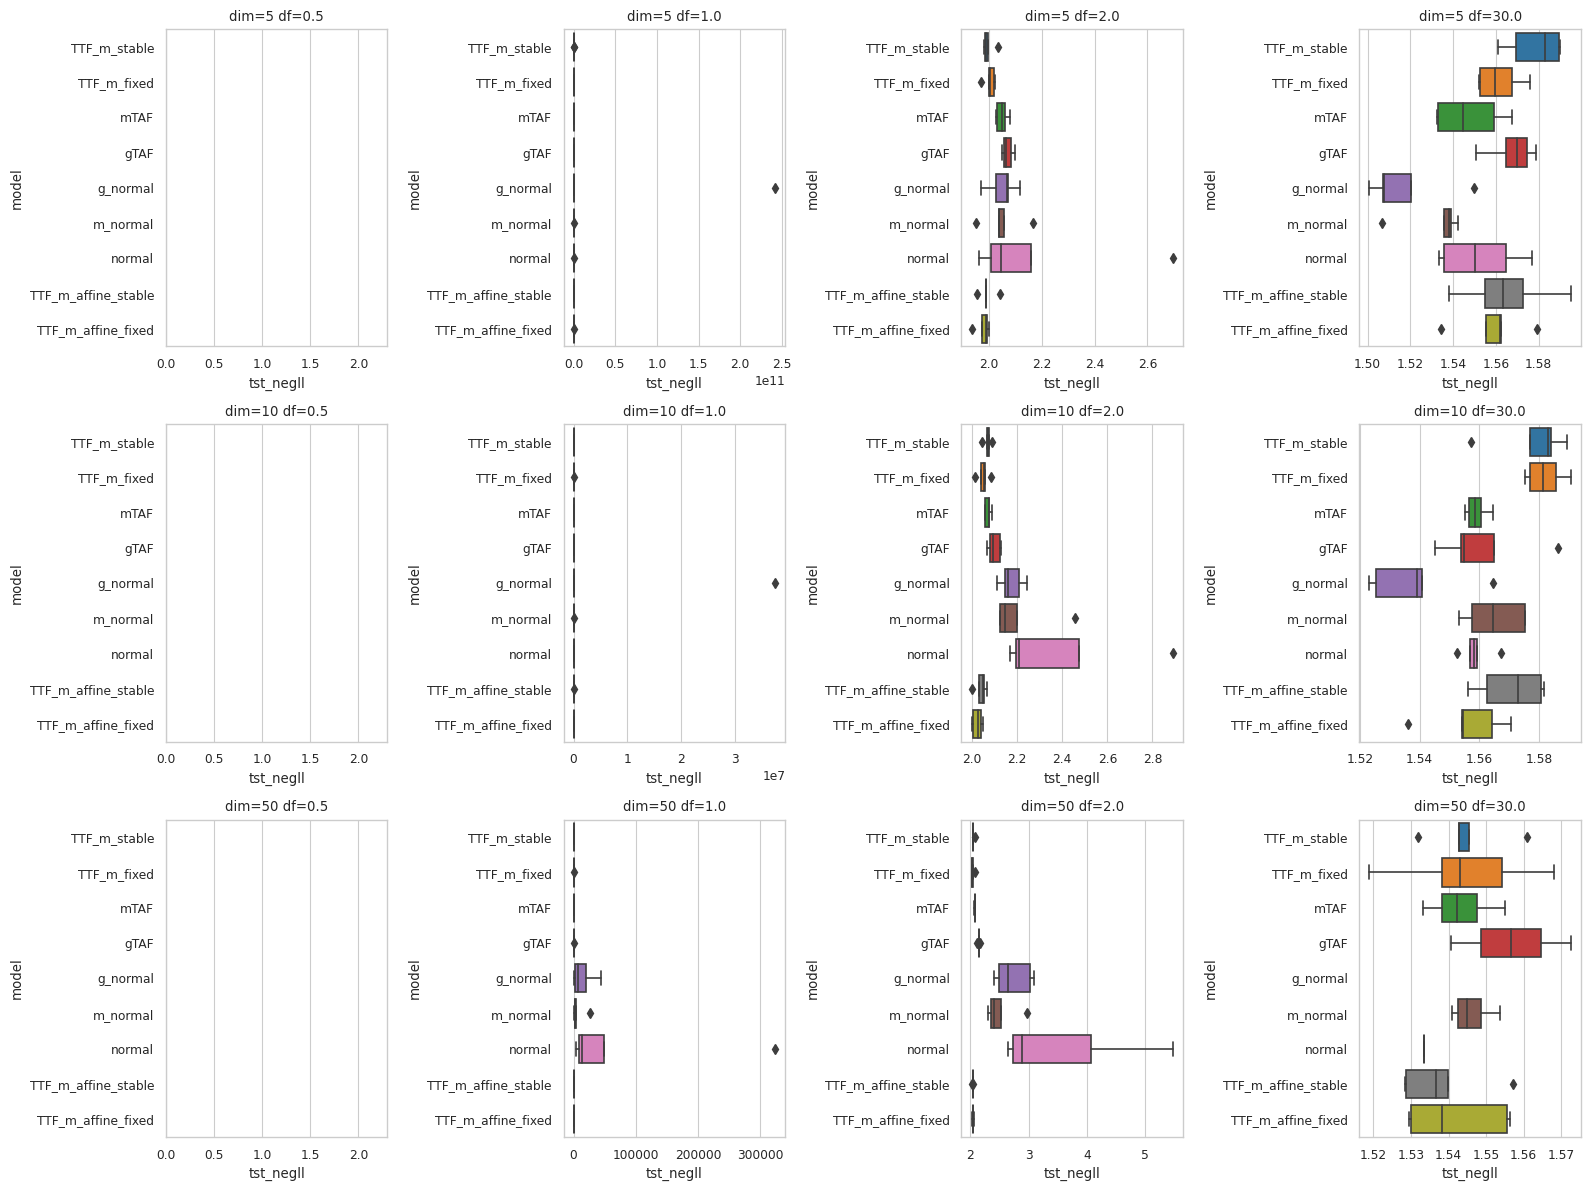

In [8]:
import seaborn as sns

wanted_dims = sorted(results['dim'].unique())
wanted_dfs = sorted(results['df'].unique())
wanted_models = results.model.unique()

fig, axarr = plt.subplots(len(wanted_dims), len(wanted_dfs), figsize=(16, 12), tight_layout=True)

if len(wanted_dims) == 1 and len(wanted_dfs) == 1:
  axarr = [[axarr]]

sns.set_style("whitegrid")
sns.set_context("paper", font_scale=1.)

for i, dim in enumerate(wanted_dims):
  for j, nuisance_df in enumerate(wanted_dfs):
    wanted_data = results[np.logical_and(
        results['dim'] == dim,
        results['df'] == nuisance_df,
    )]

    sns.boxplot(
        data=wanted_data,
        x='tst_negll',
        y='model',
        order=wanted_models,
        orient='h',
        ax=axarr[i][j],
    )

    axarr[i][j].set_title(f'dim={dim} df={nuisance_df:.1f}')

    if j == 0:
      axarr[i][j].set_xlim([0., 2.3])

In [44]:
agg = results.groupby(['dim', 'df', 'model'], group_keys=False).agg(['mean', 'sem'])

unpacked_rows = []
for (dim, df, model), test_neg_ll_agg in agg.iterrows():
    unpacked_rows.append(
        {
            'model': model,
            'df': df,
            'dim': dim,
            'tst_negll': test_neg_ll_agg.values[0],
            'sem': test_neg_ll_agg.values[1],
        }
    )

rezzas = pd.DataFrame(unpacked_rows)

In [49]:
def readable(row):
    if row["tst_negll"] > 10000 or np.isnan(row["tst_negll"]):
        return 'null'
    else:
        return  f'{row["tst_negll"]:.2f} ({row["sem"]:.2f})'
    
def interval(row):
    if row["tst_negll"] > 10000 or np.isnan(row["tst_negll"]):
        return 'null'
    else:
        return  f'[{row["tst_negll"] - row["sem"]:.4f}, {row["tst_negll"] + row["sem"]:.4f}]'
    
rezzas['readable'] = rezzas.apply(readable, axis=1)
rezzas['interval'] = rezzas.apply(interval, axis=1)

selector = np.logical_and(
    rezzas['dim'] == 50,
    np.isin(
        rezzas['df'], [0.5, 1., 2., 30.]
    ),
    # np.isin(
    #     rezzas['model'],
    #     ['TTF_m_affine_stable', 'TTF_m_stable']
    # )
)

res_tab = rezzas[selector].pivot(index='model', columns='df')['readable']
res_tab

df,0.5,1.0,2.0,30.0
model,,,,
TTF_m_affine_fixed,3.75 (0.01),2.61 (0.00),2.05 (0.00),1.54 (0.01)
TTF_m_affine_stable,3.75 (0.00),2.62 (0.00),2.05 (0.00),1.54 (0.01)
TTF_m_fixed,3.75 (0.01),2.63 (0.01),2.04 (0.01),1.54 (0.01)
TTF_m_stable,3.75 (0.01),2.63 (0.00),2.06 (0.01),1.54 (0.00)
gTAF,15.65 (0.37),4.41 (0.10),2.15 (0.01),1.56 (0.01)
g_normal,null,null,2.73 (0.14),NaN
mTAF,4.51 (0.04),2.78 (0.01),2.08 (0.01),1.54 (0.00)
m_normal,null,6808.11 (4774.30),2.52 (0.12),1.55 (0.00)
normal,null,null,3.56 (0.54),1.53 (nan)


In [53]:
rezzas[selector].pivot(index='model', columns='df')['interval']

df,0.5,1.0,2.0,30.0
model,,,,
TTF_m_affine_fixed,"[3.7449, 3.7551]","[2.6112, 2.6177]","[2.0427, 2.0509]","[1.5360, 1.5479]"
TTF_m_affine_stable,"[3.7514, 3.7564]","[2.6128, 2.6200]","[2.0424, 2.0478]","[1.5329, 1.5434]"
TTF_m_fixed,"[3.7428, 3.7626]","[2.6241, 2.6343]","[2.0345, 2.0527]","[1.5363, 1.5527]"
TTF_m_stable,"[3.7439, 3.7595]","[2.6284, 2.6332]","[2.0510, 2.0628]","[1.5401, 1.5495]"
gTAF,"[15.2807, 16.0285]","[4.3102, 4.5121]","[2.1428, 2.1608]","[1.5474, 1.5658]"
g_normal,null,null,"[2.5913, 2.8660]",NaN
mTAF,"[4.4728, 4.5484]","[2.7671, 2.7876]","[2.0734, 2.0845]","[1.5395, 1.5470]"
m_normal,null,"[2033.8064, 11582.4108]","[2.3950, 2.6360]","[1.5434, 1.5490]"
normal,null,null,"[3.0183, 4.1059]","[nan, nan]"


In [52]:
order = {
    'normal': 'normal',
    'm_normal': 'm\_normal',
    'g_normal': 'g\_normal',
    'gTAF': 'gTAF',
    'TTF_m_affine_stable': 'TTF',
    'mTAF': 'mTAF',
    'TTF_m_affine_fixed': 'TTF (fix)',
    # 'comet': 'COMET'
}

for m_name, l_name in order.items():
    parsed_vals= [
        val if isinstance(val, str) else 'null'
        for val in res_tab.loc[m_name]
    ]
    print(f'& {l_name} &', ' & '.join(parsed_vals), ' \\\\')

& normal & null & null & 3.56 (0.54) & 1.53 (nan)  \\
& m\_normal & null & 6808.11 (4774.30) & 2.52 (0.12) & 1.55 (0.00)  \\
& g\_normal & null & null & 2.73 (0.14) & null  \\
& gTAF & 15.65 (0.37) & 4.41 (0.10) & 2.15 (0.01) & 1.56 (0.01)  \\
& TTF & 3.75 (0.00) & 2.62 (0.00) & 2.05 (0.00) & 1.54 (0.01)  \\
& mTAF & 4.51 (0.04) & 2.78 (0.01) & 2.08 (0.01) & 1.54 (0.00)  \\
& TTF (fix) & 3.75 (0.01) & 2.61 (0.00) & 2.05 (0.00) & 1.54 (0.01)  \\


In [ ]:

for m_name, l_name in order.items():
    parsed_vals= [
        val if isinstance(val, str) else 'null'
        for val in res_tab.loc[m_name]
    ]
    print(f'& {l_name} &', ' & '.join(parsed_vals), ' \\\\')